<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Modelo de lenguaje con tokenización por caracteres

- Procesamiento del Lenguaje Natural - FIUBA
- Autor: Leandro Saraco
- CEIA
- Septiembre 2024


## Consigna
- 1. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- 2. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- 3. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- 4. Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [2]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## 1. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

Como fuente de datos se utilizará el dataset de reviews de películas de IMDB.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Cargo el dataset de IMDB
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Inicializo listas
train_reviews = []
test_reviews = []

# El dataset original viene dividido en train y test para hacer aprendizaje supervisado de sentiment análisis.
# en este caso queremos sólo los textos, por lo cual se junta todo para formar el corpus.
for review, _ in tfds.as_numpy(dataset['train']):
    train_reviews.append(review.decode('utf-8'))

for review, _ in tfds.as_numpy(dataset['test']):
    test_reviews.append(review.decode('utf-8'))

corpus = train_reviews + test_reviews


2024-09-23 00:00:17.973710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 00:00:18.126290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 00:00:18.168220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 00:00:18.459534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 00:00:20.233599: W tensorflow/compiler/tf2

In [3]:
corpus[0]

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [10]:
# Se convierten todos los reviews a un gran texto
all_reviews_single_text = ' '.join(corpus)

In [14]:
print("Tamaño total de caracteres:",len(all_reviews_single_text))

long: 65521550


- Como se tienen muchos caracteres, para poder manejar el modelo con los recursos computacionales disponibles se limitará el número de reviews a procesar
- Se apunta a aproximadamente 500000 caracteres, para tener una buena cantidad de datos. 
- Se limita entonces de 50000 a 410

In [55]:
# Se convierten todos los reviews a un gran texto
corpus_ = corpus[:410]
all_reviews_single_text = ' '.join(corpus_)
print("Tamaño total del texto en caracteres:",len(all_reviews_single_text))

Tamaño total del texto en caracteres: 505018


Para reducir aun más la complejidad del compu, se convierte todo el texto a minúsculas

In [56]:
all_reviews_single_text = all_reviews_single_text.lower()

### Elección del tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [57]:
# Seleccionamos el tamaño de contexto
max_context_size = 100

In [58]:
# En este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(all_reviews_single_text)
print(f"La longitud del vocabulario de caracteres es: {len(chars_vocab)}")

La longitud del vocabulario de caracteres es: 86


In [59]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

## 2. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

In [60]:
# Tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in all_reviews_single_text]

In [61]:
tokenized_text[:100]

[18,
 14,
 27,
 11,
 54,
 77,
 15,
 11,
 54,
 15,
 60,
 54,
 15,
 5,
 11,
 69,
 59,
 81,
 18,
 58,
 59,
 23,
 54,
 18,
 58,
 28,
 28,
 27,
 5,
 59,
 58,
 54,
 4,
 69,
 70,
 27,
 58,
 45,
 54,
 12,
 69,
 60,
 26,
 18,
 54,
 5,
 58,
 54,
 59,
 81,
 28,
 58,
 12,
 54,
 27,
 60,
 54,
 5,
 23,
 54,
 79,
 14,
 28,
 27,
 11,
 18,
 69,
 21,
 14,
 58,
 28,
 54,
 77,
 15,
 59,
 73,
 58,
 60,
 54,
 69,
 28,
 54,
 4,
 27,
 79,
 14,
 15,
 58,
 59,
 54,
 27,
 28,
 69,
 60,
 11,
 27,
 12,
 58,
 45,
 54]

### Organizando y estructurando el dataset

In [62]:
# Separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [63]:
# Separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [64]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [65]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [66]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [67]:
X.shape

(454318, 100)

In [68]:
X[0,:10]

array([18, 14, 27, 11, 54, 77, 15, 11, 54, 15])

In [69]:
y[0,:10]

array([14, 27, 11, 54, 77, 15, 11, 54, 15, 60])

In [70]:
vocab_size = len(chars_vocab)
vocab_size

86

## 3. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.


In [71]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

### 3.a. Model usando SimpleRNN

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [72]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

/home/idk/git/ceia/procesamiento_lenguaje_natural/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 86)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 200)      │        57,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 86)       │        17,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,686 (291.74 KB)

 Trainable params: 74,686 (291.74 KB)

 Non-trainable params: 0 (0.00 B)


### Definición del modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,name="model",patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.name = name
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"{self.name}.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [74]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=15, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,"model_rnn")], batch_size=256)

Epoch 1/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 2.4612
 mean perplexity: 6.4184802678929795 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 565s 315ms/step - loss: 2.4610
Epoch 2/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 1.9021
 mean perplexity: 5.927964837809603 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 534s 301ms/step - loss: 1.9021
Epoch 3/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.8151
 mean perplexity: 5.828716497148762 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 485s 273ms/step - loss: 1.8151
Epoch 4/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 1.7816
 mean perplexity: 5.606873049795968 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 450s 254ms/step - loss: 1.7816
Epoch 5/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 1.7644
 mean perplexity: 5.606525349464914 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 427s 240ms/step - loss: 1.7644
Epoch 6/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - l

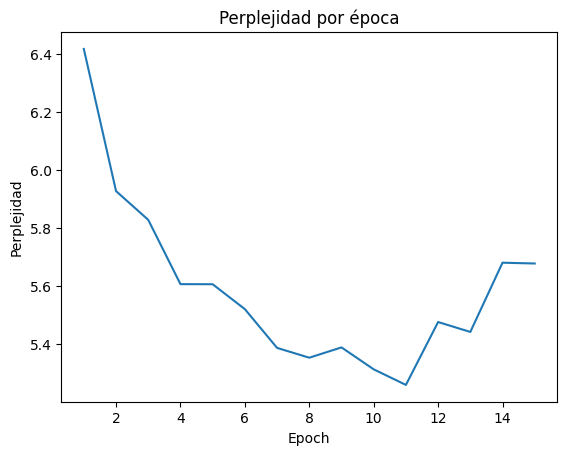

In [76]:
import seaborn as sns
# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.title("Perplejidad por época")
plt.xlabel("Epoch")
plt.ylabel("Perplejidad")
plt.show()



### Predicción del próximo caracter

In [77]:
def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

In [78]:
model_response("I didn't liked that movi")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


"I didn't liked that movie"

### 3.b. Modelo utilizando LSTM

In [79]:
model_lstm = Sequential()

model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()

/home/idk/git/ceia/procesamiento_lenguaje_natural/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 86)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       229,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 86)       │        17,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,886 (964.40 KB)

 Trainable params: 246,886 (964.40 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model_lstm.fit(X, y, epochs=15, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,"model_lstm")], batch_size=256)

Epoch 1/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 2.7110
 mean perplexity: 8.502792052693293 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 837s 469ms/step - loss: 2.7109
Epoch 2/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 2.1761
 mean perplexity: 7.378873224447114 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 832s 469ms/step - loss: 2.1761
Epoch 3/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 2.0589
 mean perplexity: 6.892921522060748 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 831s 468ms/step - loss: 2.0589
Epoch 4/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 1.9827
 mean perplexity: 6.498910311251051 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 832s 469ms/step - loss: 1.9827
Epoch 5/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 1.9310
 mean perplexity: 6.278831252582771 

Saved new model!
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 830s 467ms/step - loss: 1.9310
Epoch 6/15
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - lo

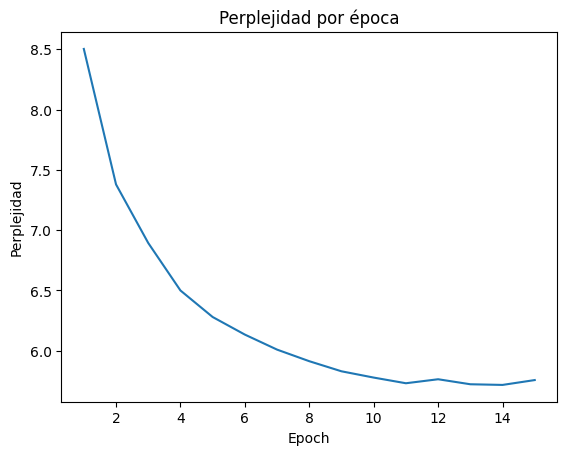

In [81]:
import seaborn as sns
# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.title("Perplejidad por época")
plt.xlabel("Epoch")
plt.ylabel("Perplejidad")
plt.show()

## 4. Generación de secuencias

Función para generar secuencias

In [82]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

### Comparación entre ambos modelos

In [83]:
input_text='The scene where the'

In [84]:
#Con SimpleRNN
generate_seq(model, input_text, max_length=max_context_size, n_words=40)

'The scene where the story is a superation of the story is a'

In [85]:
#Con LSTM
generate_seq(model_lstm, input_text, max_length=max_context_size, n_words=40)

'The scene where the story is a supposed the story is a supp'

###  Beam search y muestreo aleatorio

In [86]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [87]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

#### Variando la temperatura - modelo con LSTM

- Se elige el modelo con LSTM ya que es el que tiene mejor performance.
- Se prueba variando diferentes temperaturas:
    - 0.01
    - 1
    - 100

In [88]:
temp_ranges = [0.01,1,100]
for temp in temp_ranges:
    salidas = beam_search(model,num_beams=10,num_words=20,temp=temp, mode="sto", input="i think that the actor")
    print(f"Secuencia con temperatura {temp}",decode(salidas[0]))

KeyError: 'I'